In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  accuracy_score

In [61]:
#  ファイルの読み込み]
DATA_HOME_DIR = "./raw/"
train = pd.read_csv(DATA_HOME_DIR + 'train.csv')
test = pd.read_csv(DATA_HOME_DIR + 'test.csv')
gender_submission = pd.read_csv(DATA_HOME_DIR + 'gender_submission.csv')

前処理

In [62]:
# 前処理のためにtrainとtestを連結
train['is_test'] = 0
train['is_train'] = 1
test['is_test'] = 1 
test['is_train'] = 0

# 目的変数
Y = train['Survived']
train_X = train.drop(['Survived'], axis = 1)

# テストID
test_id = test['PassengerId']
test_X = test

# 連結
all_df = pd.concat([train_X, test_X], axis=0)

In [63]:
# 欠損値}
all_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
is_test           0
is_train          0
dtype: int64

In [64]:
# Age欠損値処理
# 男女別でPclass毎の中央値で埋め
# all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())   # 平均値
# all_df['Age'] = all_df['Age'].fillna(all_df['Age'].median()) # 中央値
# all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mode())   # 最頻値

m1 = all_df[(all_df['Sex'] == 'male') & (all_df['Pclass'] == 1)]['Age'].median()
m2 = all_df[(all_df['Sex'] == 'male') & (all_df['Pclass'] == 2)]['Age'].median()
m3 = all_df[(all_df['Sex'] == 'male') & (all_df['Pclass'] == 3)]['Age'].median()
f1 = all_df[(all_df['Sex'] == 'female') & (all_df['Pclass'] == 1)]['Age'].median()
f2 = all_df[(all_df['Sex'] == 'female') & (all_df['Pclass'] == 2)]['Age'].median()
f3 = all_df[(all_df['Sex'] == 'female') & (all_df['Pclass'] == 3)]['Age'].median()

all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'male') & (all_df['Pclass'] == 1),  'Age'] = m1
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'male') & (all_df['Pclass'] == 2),  'Age'] = m2
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'male') & (all_df['Pclass'] == 3),  'Age'] = m3
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'female') & (all_df['Pclass'] == 1),  'Age'] = f1
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'female') & (all_df['Pclass'] == 2),  'Age'] = f2
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'female') & (all_df['Pclass'] == 3),  'Age'] = f3

In [65]:
# Fare欠損値確認
all_df[all_df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,0


In [66]:
# Fare欠損値処理
# Pcalass=3の平均値で埋め
Pclass3mean = all_df[all_df['Pclass'] == 3]['Fare'].mean()
all_df['Fare'].fillna(Pclass3mean, inplace=True) 

In [67]:
all_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1
5,6,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q,0,1
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,1
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,1
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,1
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0,1


In [68]:
# Embarked欠損値確認
all_df[all_df['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,1
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,1


In [69]:
# pclass=1の人が割合が一番多いCで埋める
all_df['Embarked'].fillna('C', inplace=True) 

In [70]:
all_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [71]:
#  Ageのカテゴリ変数化
# all_df.loc[ all_df['Age']  <=  10,  'Age_c']  =  0
# all_df.loc[(all_df['Age'] >  10)  &  (all_df['Age']  <=  20),  'Age_c']  =  1
# all_df.loc[(all_df['Age'] >  40)  &  (all_df['Age']  <=  30),  'Age_c']  =  2
# all_df.loc[(all_df['Age'] >  30)  &  (all_df['Age']  <=  40),  'Age_c']  =  3
# all_df.loc[(all_df['Age'] >  40)  &  (all_df['Age']  <=  50),  'Age_c']  =  4
# all_df.loc[(all_df['Age'] >  50)  &  (all_df['Age']  <=  60),  'Age_c']  =  5
# all_df.loc[(all_df['Age'] >  60)  &  (all_df['Age']  <=  70),  'Age_c']  =  6
# all_df.loc[(all_df['Age'] >  70)  &  (all_df['Age']  <=  80),  'Age_c']  =  7
# all_df.loc[ all_df['Age']  >  80,  'Age_c']    =  8

変数追加

In [72]:
all_df['AgeBin'] = pd.cut(all_df['Age'].astype(int), 5)
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
all_df['AgeBin'] = label.fit_transform(all_df['AgeBin'])

In [73]:
all_df['FareBin'] = pd.cut(all_df['Fare'].astype(int), 5)
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
all_df['FareBin'] = label.fit_transform(all_df['FareBin'])

In [74]:
# 家族数 (自分を含める)
all_df['CountFamily'] = all_df['SibSp'] + all_df['Parch'] + 1

In [75]:
# 一人フラグ
all_df['IsHitori'] = 0
all_df.loc[all_df['CountFamily'] == 1,  'IsHitori'] = 1

In [76]:
# Cabin の先頭一文字抽出
all_df['Cabin_initial'] = all_df['Cabin'].str[:1]
all_df['Cabin_initial'].value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Cabin_initial, dtype: int64

In [77]:
all_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train,AgeBin,FareBin,CountFamily,IsHitori,Cabin_initial
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,1,0,2,0,NaN
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,2,0,2,0,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,0,1,1,NaN
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,2,0,2,0,C
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,2,0,1,1,NaN


In [78]:
all_df.loc[all_df['Sex'] == 'male', 'Sex'] = 0
all_df.loc[all_df['Sex'] == 'female', 'Sex'] = 1
all_df['Sex'].astype(int)

0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     1
15     1
16     0
17     0
18     1
19     1
20     0
21     0
22     1
23     0
24     1
25     1
26     0
27     0
28     1
29     0
      ..
388    0
389    0
390    0
391    1
392    0
393    0
394    0
395    1
396    0
397    1
398    0
399    0
400    1
401    0
402    1
403    0
404    0
405    0
406    0
407    0
408    1
409    1
410    1
411    1
412    1
413    0
414    1
415    0
416    0
417    0
Name: Sex, Length: 1309, dtype: int32

In [79]:
# nameの敬称抽出
import collections 
collections.Counter(all_df['Name'].str.extract('([A-Za-z]+)\.',  expand = False))

Counter({'Capt': 1,
         'Col': 4,
         'Countess': 1,
         'Don': 1,
         'Dona': 1,
         'Dr': 8,
         'Jonkheer': 1,
         'Lady': 1,
         'Major': 2,
         'Master': 61,
         'Miss': 260,
         'Mlle': 2,
         'Mme': 1,
         'Mr': 757,
         'Mrs': 197,
         'Ms': 2,
         'Rev': 8,
         'Sir': 1})

In [80]:
# df_trainのTitle列の値ごとに平均値を算出
all_df['Title']=  all_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
all_df.groupby('Title').mean()['Age']

Title
Capt        70.000000
Col         54.000000
Countess    33.000000
Don         40.000000
Dona        39.000000
Dr          43.375000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       8.042295
Miss        21.917654
Mlle        24.000000
Mme         24.000000
Mr          31.249670
Mrs         35.680203
Ms          25.000000
Rev         41.250000
Sir         49.000000
Name: Age, dtype: float64

In [81]:
#  変換関数
def title_to_c(title):
    if title == 'Master':
        return  'Master'
    elif title == 'Miss':
        return  'Miss'
    elif title == 'Mr':
        return  'Mr'
    elif title == 'Mrs':
        return  'Mrs'
    else:
        return  'other'
#  リスト内包表記を用いて変換
all_df['Title'] = [title_to_c(i) for i in all_df['Title']]

In [82]:
all_df.drop(['Name', 'Cabin', 'Ticket', 'SibSp', 'Parch', 'Age', 'Fare'],  axis=1,  inplace=True)

In [83]:
# カテゴリ変数を取得する関数
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# カテゴリ変数をファクトライズ (整数に置換)する関数
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# カテゴリ変数のダミー変数 (二値変数化)を作成する関数
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

In [84]:
# カテゴリ変数を取得
all_df_cats = _get_categorical_features(all_df)
all_df_cats

['Embarked', 'Cabin_initial', 'Title']

In [85]:
# ダミー変数を取得
all_df = _get_dummies(all_df, all_df_cats)
all_df.drop(all_df_cats,  axis=1,  inplace=True)
all_df.head()

,PassengerId,Pclass,Sex,is_test,is_train,AgeBin,FareBin,CountFamily,IsHitori,Embarked_C,...,Cabin_initial_D,Cabin_initial_E,Cabin_initial_F,Cabin_initial_G,Cabin_initial_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_other
0,1,3,0,0,1,1,0,2,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,1,0,1,2,0,2,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3,3,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,4,1,1,0,1,2,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,3,0,0,1,2,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [86]:
# 最終的なtrainとtestデータを用意
ignore_features = ['PassengerId', 'is_train', 'is_test']
relevant_features = [col for col in all_df.columns if col not in ignore_features]
trainX = all_df[all_df['is_train'] == 1][relevant_features]
testX = all_df[all_df['is_test'] == 1][relevant_features]

In [87]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
# 3分割交差検証を指定し、インスタンス化
kf = KFold(n_splits=3)
# 3分割し、交差検証
for  train_index,  test_index  in kf.split(trainX, Y):
    X_cv_train  = trainX.iloc[train_index]
    X_cv_test  = trainX.iloc[test_index]
    Y_cv_train  = Y.iloc[train_index]
    Y_cv_test  = Y.iloc[test_index]

    forest  =  RandomForestClassifier(random_state=17)
    forest.fit(X_cv_train, Y_cv_train)  

    predictions  = forest.predict(X_cv_test) 

    # acuuracyを表示
    print(round(accuracy_score(Y_cv_test,forest.predict(X_cv_test))*100,2))

77.78
80.81
82.15


([<matplotlib.axis.YTick at 0x14d25373908>,
 <a list of 22 Text yticklabel objects>)

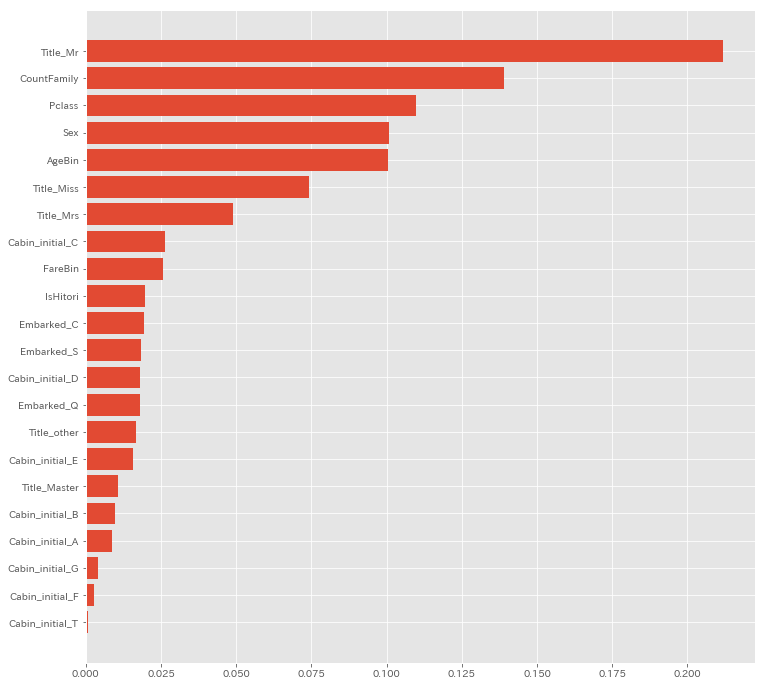

In [88]:
values, names = zip(*sorted(zip(forest.feature_importances_, trainX.columns)))

plt.figure(figsize=(12,12))
plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)

In [59]:
forest.fit(trainX, Y)
# 予測
pred = forest.predict(testX)
# 提出用
gender_submission["Survived"] = pred
gender_submission.to_csv('./submit/submit_forest09.csv',index=None)